# TP 2: Expectation-Maximisation algorithm - Importance sampling
## Author: Clément Bonnet

---

## Exercise 1: Discrete distributions

### 1.
To generate a random variable $X$ having the discrete distribution on $\{ x_1,\dots,x_n \}$ given by $(p_i)_{i \in [\![1,n]\!]}$, one can sample a uniform random variable between $0$ and $1$ and then use the cumulative distribution function over the probabilities $(p_i)_{i \in [\![1,n]\!]}$.
The algorithm is the following:
- Sample $U \sim U([0,1])$
- Return $x_{i_0}$ where $i_0 = \min \{i \in [1,n]\ | \ \sum_{j=1}^i p_j > U \}$

### 2.


In [1]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def discrete_distribution(X, P):
    # Check whether P represents a probability and P is the same length as X
    assert np.isclose(P.sum(), 1), "P is not a probability array in the sense that it does not sum up to 1."
    assert len(X) == len(P), "P and X do not have the same dimension."
    cum = P.cumsum()
    u = np.random.rand()
    for i, x in enumerate(X):
        if cum[i] > u : return x 

### 3.

In [3]:
N = 10000
X = np.array([2, 4, 6, 7, 9])
P = np.array([0.1, 0.2, 0.3, 0.1, 0.3])
Y = np.array([discrete_distribution(X, P) for _ in range(N)])

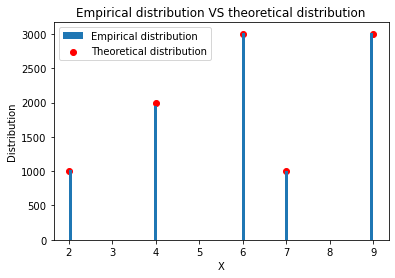

In [4]:
plt.hist(Y, bins=100, label="Empirical distribution");
plt.scatter(X, N*P, color="red", label="Theoretical distribution");
plt.legend();
plt.xlabel("X");
plt.ylabel("Distribution");
plt.title("Empirical distribution VS theoretical distribution");

As one can see, for large values of $N$ (here, $N=10000$), the empirical distribution does approximate very well the theoretical one.

---

## Exercise 2: Gaussian mixture model and the EM algorithm

### 1.
The parameters are $\theta = (\alpha_1,\dots,\alpha_m,\mu_1,\dots,\mu_m,\Sigma_1,\dots,\Sigma_m)$.

$$
\begin{aligned}
L(x_1,\dots,x_n;\theta)
&= \prod_{i=1}^n f_{\theta}(x_i) \\
&= \prod_{i=1}^n \sum_{k=1}^m \alpha_k \frac{1}{|\Sigma_k|\sqrt{(2\pi)^d}}\exp \big(-\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \big) \\
l(x_1,\dots,x_n;\theta) &= \sum_{i=1}^n \log \Big( \sum_{k=1}^m \alpha_k \frac{1}{|\Sigma_k|\sqrt{(2\pi)^d}}\exp \big(-\frac{1}{2} (x_i - \mu_k)^T \Sigma_k^{-1} (x_i - \mu_k) \big) \Big) \\
\end{aligned}
$$

### 2.

In [5]:
def gaussian_mixture(alphas, means, sigmas):
    # Sample a cluster
    k = discrete_distribution(np.arange(len(means)), alphas)
    # Return an observation sampled from the corresponding Gaussian distribution
    return np.random.multivariate_normal(means[k], sigmas[k])

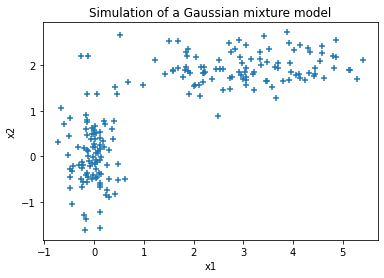

In [6]:
np.random.seed(0)
n = 200
alphas = np.array([0.5,0.5])
means = np.array([[0,0],[3,2]])
sigmas = np.array([[[0.1,0],[0,0.5]],[[1.5,0],[0,0.1]]])
XY = np.array([gaussian_mixture(alphas, means, sigmas) for _ in range(n)])
X, Y = XY[:,0], XY[:,1]
plt.scatter(X, Y, marker="+");
plt.xlabel("x1");
plt.ylabel("x2");
plt.title("Simulation of a Gaussian mixture model");

### 3.

### EM algorithm:
- Expectation step:
$$
\mathbb{E}[l(x,z,\theta)\ |\ x, \theta_t] = -n\frac{d}{2}\log(2\pi) + \sum_{i=1}^n \sum_{j=1}^m \big( -\log|\Sigma_j| - \frac{1}{2}(x_i - \mu_j)^T\Sigma_j^{-1}(x_i - \mu_j) + \log \alpha_j \big)\mathbb{P}_{i,j}^t \\
\text{with}\quad \mathbb{P}_{i,j}^t = \mathbb{P}(z_i=j\ |\ x; \theta_t) = \frac{\frac{\alpha_j^t}{|\Sigma_j^t|\sqrt{(2\pi)^d}}\exp \big(-\frac{1}{2} (x_i - \mu_j^t)^T \Sigma_j^{t^{-1}} (x_i - \mu_j^t) \big)}{\sum_{k=1}^m \frac{\alpha_k^t}{|\Sigma_k^t|\sqrt{(2\pi)^d}}\exp \big(-\frac{1}{2} (x_i - \mu_k^t)^T \Sigma_k^{t^{-1}} (x_i - \mu_k^t) \big)}
$$

- Mazimization step:
$$
\begin{aligned}
    \alpha_k^{t+1} &= \frac{\sum_{i=1}^n \mathbb{P}_{i,k}^t}{\sum_{j=1}^m \sum_{i=1}^n \mathbb{P}_{i,j}^t} \\
    \mu_k^{t+1} &= \frac{\sum_{i=1}^n x_i \mathbb{P}_{i,k}^t}{\sum_{i=1}^n \mathbb{P}_{i,k}^t} \\
    \Sigma_k^{t+1} &= \frac{\sum_{i=1}^n \mathbb{P}_{i,k}^t (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^n \mathbb{P}_{i,k}^t}
\end{aligned}
$$

In [7]:
def Pt(X, alphas, means, sigmas):
    """
    Return a matrix whose coordinate (i,j) is P(z_i = j | x ; theta_t).
    """
    n = X.shape[0]
    (m, d) = means.shape
    alphas, means, sigmas = check_singularity(alphas, means, sigmas, X, len(alphas))
    P = np.array([[(alphas[j]/(np.abs(np.linalg.det(sigmas[j]))*np.sqrt((2*np.pi)**d)))*np.exp(-1/2 * (X[i] - means[j]).T@np.linalg.inv(sigmas[j])@(X[i] - means[j])) for j in range(m)] for i in range(n)])
    P = P/P.sum(axis=1)[:,np.newaxis]
    return P
    
def log_like(X, m, alphas, means, sigmas):
    """
    Return the log-likelihood.
    """
    n = X.shape[0]
    (m, d) = means.shape
    alphas, means, sigmas = check_singularity(alphas, means, sigmas, X, len(alphas))
    q = -n*d/2 * np.log(2*np.pi) + (np.array( [[np.log(alphas[j]) - np.log(np.abs(np.linalg.det(sigmas[j]))) - 1/2 * (X[i] - means[j]).T@np.linalg.inv(sigmas[j])@(X[i] - means[j]) for j in range(m)] for i in range(n)])*Pt(X, alphas, means, sigmas)).sum()
    return q
    
def check_singularity(alphas, means, sigmas, X, m):
    """
    Check whether a covariance matrix is singular.
    """
    for k in range(len(sigmas)):
        while np.isclose(np.linalg.det(sigmas[k]), 0, atol=1e-3):
            sigmas[k] = np.diag(np.random.rand(X.shape[1]))
    return alphas, means, sigmas

def initialize_param(X, m):
    """
    Initialize parameters.
        - alphas: 1/m
        - means: randomly choose m data points
        - sigmas: Gaussian
    """
    alphas = np.ones(m)/m
    means = X[np.random.choice(X.shape[0], m, replace=False), :].copy()
#     sigmas = np.array([np.diag(np.random.rand(X.shape[1])) for _ in range(m)])
    sigmas = np.array([np.identity(X.shape[1]) for _ in range(m)])
    return alphas, means, sigmas

def em_gmm(X, m, eps=1e-1):
    """
    EM algorithm that determines the parameters of a Gaussian Mixture Model.
    Inputs:
        X: array of shape (n,d)
        m: number of clusters (an assumption has to be made)
        eps: stopping criterion of the EM algorithm
    Outputs: (param, log)
        param: dictionary whose keys are alphas, means, sigmas and whose values are parameters found by the algorithm
        log: list of log-likelihood values over time for monitoring purposes
    """
    n = X.shape[0]
    # Random initialization
    alphas, means, sigmas = initialize_param(X, m)
    q = log_like(X, m, alphas, means, sigmas)
    log = []
    stop_crit = False
    while not stop_crit:
        P = Pt(X, alphas, means, sigmas)
        # Update of parameters to increase the likelihood
        sigmas = np.array([[P[i,j]*((X[i]-means[j]).reshape(-1,1))@((X[i]-means[j]).reshape(-1,1)).T for j in range(m)] for i in range(n)]).sum(axis=0)/(P.sum(axis=0).reshape(-1,1,1))
        means = (P.T@X)/(P.sum(axis=0).reshape(-1,1))
        alphas = P.sum(axis=0)/P.sum()
        alphas, means, sigmas = check_singularity(alphas, means, sigmas, X, m)
        new_q = log_like(X, m, alphas, means, sigmas)
        log.append(new_q)
        if np.abs(new_q - q) < eps:
            stop_crit = True
        q = new_q
    param = {"alphas": alphas, "means": means, "sigmas": sigmas}                    
    return log, param

    
            

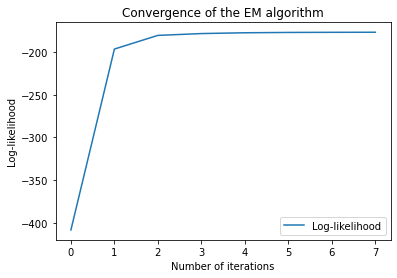

In [8]:
m = 2
log, param = em_gmm(XY, m)

plt.plot(log, label="Log-likelihood");
plt.legend();
plt.xlabel("Number of iterations");
plt.ylabel("Log-likelihood");
plt.title("Convergence of the EM algorithm");

### 4.

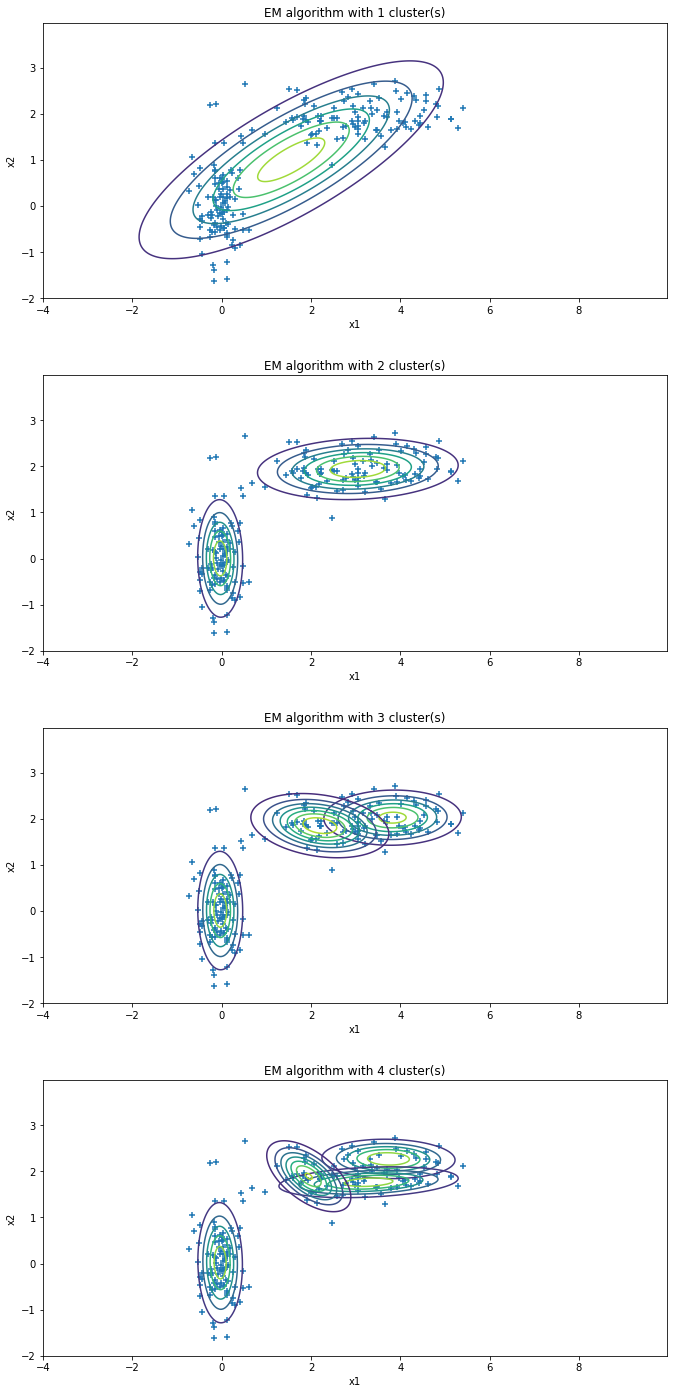

In [9]:
# Contour plots
m_max = 4   # maximal number of clusters
plt.figure(figsize=(10,m_max*5));
for m in range(1, m_max+1):
    log, param = em_gmm(XY, m)
    X, Y = XY[:,0], XY[:,1]
    plt.subplot(m_max,1,m);
    plt.scatter(X, Y, marker="+");
    plt.xlabel("x1");
    plt.ylabel("x2");
    plt.title("EM algorithm with {} cluster(s)".format(m));
    for k in range(m):
        dist = multivariate_normal(mean=param["means"][k], cov=param["sigmas"][k])
        delta = 0.025
        x = np.arange(-4.0, 10.0, delta)
        y = np.arange(-2.0, 4.0, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[dist.pdf([X[i,j],Y[i,j]]) for j in range(X.shape[1])] for i in range(X.shape[0])])
        plt.contour(X,Y,Z);
plt.tight_layout(pad=3.0);

For 2 clusters, the EM algorithm estimates the original parameters very well.

In [10]:
# Display parameters
_, param = em_gmm(XY, 2)
for i, parameter in enumerate(["Alphas", "Means", "Sigmas"]):
    print("   ", parameter)
    print("\nTrue: \n{}\n\nEstimated: \n{}\n".format([alphas,means,sigmas][i], param[parameter.lower()].round(2)))

    Alphas

True: 
[0.5 0.5]

Estimated: 
[0.48 0.52]

    Means

True: 
[[0 0]
 [3 2]]

Estimated: 
[[-0.03  0.  ]
 [ 3.05  1.94]]

    Sigmas

True: 
[[[0.1 0. ]
  [0.  0.5]]

 [[1.5 0. ]
  [0.  0.1]]]

Estimated: 
[[[ 0.07 -0.01]
  [-0.01  0.46]]

 [[ 1.3   0.05]
  [ 0.05  0.11]]]



### 5.

In [11]:
df = pd.read_csv("data.csv").dropna()

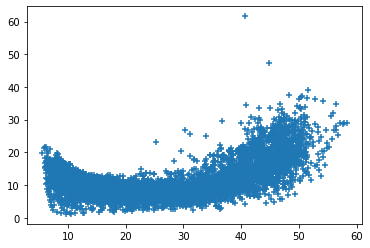

In [12]:
df = df[["CBR", "CDR"]]
plt.scatter(df["CBR"], df["CDR"], marker="+");

The data seem to have a kind of bent shape that a Gaussian mixture model would adapt to. It seems that the model could fit the data to 3 clusters. 

### 6.

In [13]:
def bic(q, param, n):
    """
    Return the Bayesian Information Criterion for the Gaussian mixture model.
    Inputs:
        - q: log_likelihood
        - param: dictionary containing the model's parameters
        - n: number of data points
    """
    freedom_param = sum(parameter.size for parameter in param.values())
    return -q +(np.log(n)*freedom_param)/2

Starting EM with m=1...
Finished EM with m=1
Starting EM with m=2...
Finished EM with m=2
Starting EM with m=3...
Finished EM with m=3
Starting EM with m=4...
Finished EM with m=4


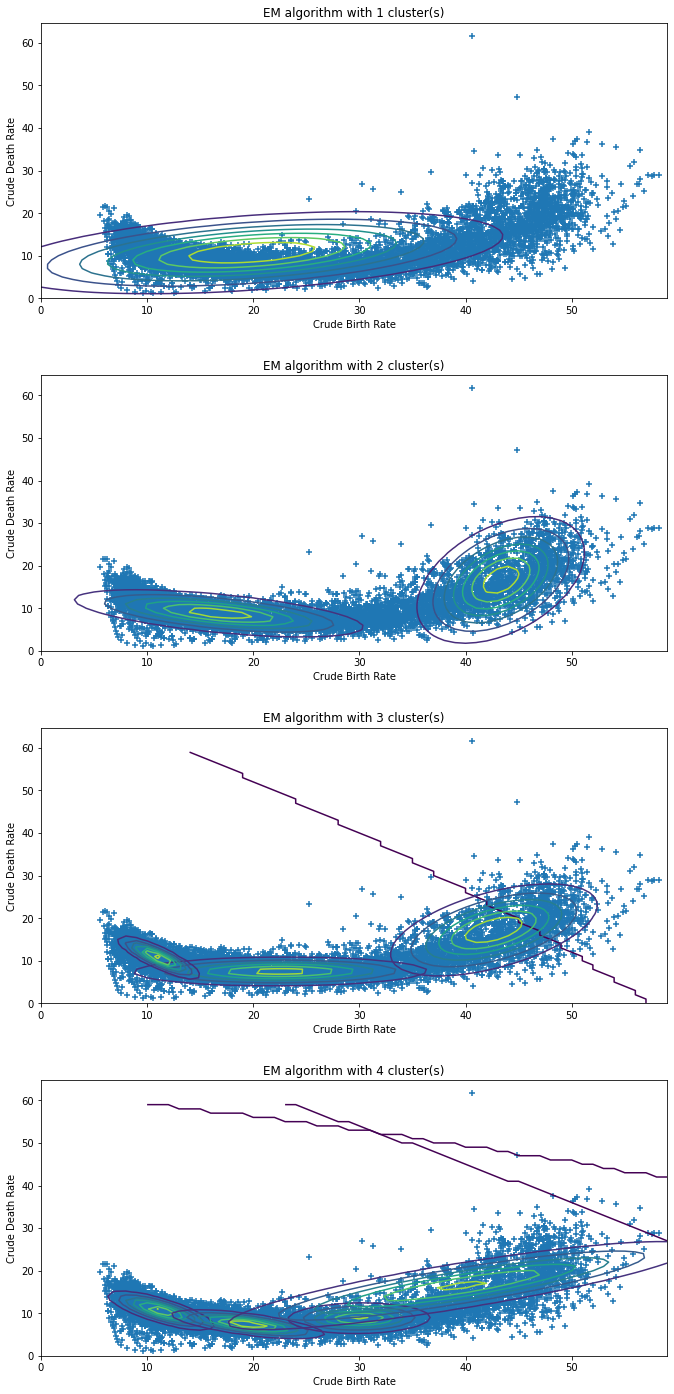

In [20]:
# Contour plots
m_max = 4   # maximal number of clusters
plt.figure(figsize=(10,m_max*5));
bics = np.zeros(m_max)
for m in range(1, m_max+1):
    n_points = 100
    indices = np.random.permutation(np.arange(len(df)))[:n_points]
    XY = df.to_numpy()[indices]
    print("Starting EM with m={}...".format(m))
    log, param = em_gmm(XY, m)
    print("Finished EM with m={}".format(m))
    bics[m-1] = bic(q=log[-1], param=param, n=n_points)
    XY = df.to_numpy()
    X, Y = XY[:,0], XY[:,1]
    plt.subplot(m_max,1,m);
    plt.scatter(X, Y, marker="+");
    plt.xlabel("Crude Birth Rate");
    plt.ylabel("Crude Death Rate");
    plt.title("EM algorithm with {} cluster(s)".format(m));
    for k in range(m):
        dist = multivariate_normal(mean=param["means"][k], cov=param["sigmas"][k])
        delta = 1
        x = np.arange(0, 60, delta)
        y = np.arange(0, 60, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.array([[dist.pdf([X[i,j],Y[i,j]]) for j in range(X.shape[1])] for i in range(X.shape[0])])
        plt.contour(X,Y,Z);
plt.tight_layout(pad=3.0);

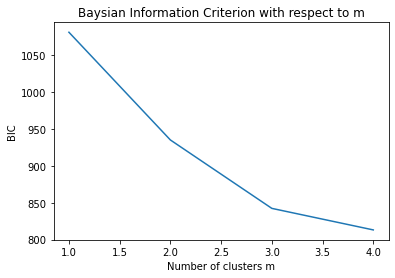

In [249]:
plt.plot(range(1,m_max+1), bics);
plt.title("Baysian Information Criterion with respect to m");
plt.xlabel("Number of clusters m");
plt.ylabel("BIC");

Since the data are continuously spread along the bent shape, it seems it would require an infinite amount of Gaussian mixtures to fit the distribution. Therefore, the BIC keeps decreasing and a GMM does not seem to be of great interest here.

---

## Exercise 3: Importance sampling

### 3.A - Poor Importance Sampling

### 1.
$$
\mathbb{E}_p[f(X)] = \mathbb{E}_q\big[\frac{p(X)}{q(X)}f(X)\big] \approx \frac{1}{N} \sum_{i=1}^N \frac{p(x_i)}{q(x_i)} f(x_i)
$$

In [244]:
p = lambda x: x**(1.65 - 1)*np.exp(-x**2/2) if x >= 0 else 0
q = lambda x, mu: 2/np.sqrt(2*np.pi*1.5) * np.exp(-(mu-x)**2/(2*1.5))
f = lambda x: 2*np.sin(np.pi*x/1.5) if x >= 0 else 0

def poor_importance_sampling(N, mu=0.8):
    # Simulate Gaussian, sampling from q
    X = mu + np.sqrt(1.5)*np.random.randn(N)
    return sum(p(x_i)*f(x_i)/q(x_i, mu) for x_i in X if x_i > 0)/N

### 2.

In [245]:
for N in [10, 100, 1000, 10000]:
    print("N = {:5d}: importance sampling = {:.3f}".format(N, poor_importance_sampling(N)))

N =    10: importance sampling = 0.201
N =   100: importance sampling = 0.503
N =  1000: importance sampling = 0.351
N = 10000: importance sampling = 0.377


If one runs several times the experiment, one can observe very high variance for small values of N.

### 3.

In [246]:
print("After shifting the mean of q to 6.")
for N in [10, 100, 1000, 10000]:
    print("N = {:5d}: importance sampling = {:.3f}".format(N, poor_importance_sampling(N, mu=6)))

After shifting the mean of q to 6.
N =    10: importance sampling = -0.574
N =   100: importance sampling = 0.006
N =  1000: importance sampling = 4.867
N = 10000: importance sampling = 0.054


The support of q is far from the one of p, which means importance sampling has very high variance and struggles to converge to the expectation of f even for large values of N.